# Batch Job Analysis -- Master Batch Job - Elapsed Time Prediction

1. Read joined widetable data file for Master Batch Job, which generated from  "2_BatchJob_MBJ_DataExploration.ipynb"
2. Seperate data into train & test parts
3. Train model with 3 different combination
4. Emsemble 3 algorithm results as final result
5. Visualization and evaluation of test result
6. When there is systemetic drift of test result, additional adjustment for predicted result


### Define parameters
Define parameters indicate input path, file, split date and target column for prediction<p>
p_file_path: path where input file widetable_MBJ.csv located<br>
p_jobname: job name, here use "MBJ" for Master Batch Job data<br>
p_filename: the file with data ready for prediction <br>
p_split_date: the date to split data into train data and test data, before it for train, the date equal and later than it is for test<br>
p_target_name: the column name in data for predict <br>




In [1]:

p_file_path=''
p_jobname='MBJ'
p_filename=p_file_path+'widetable_'+p_jobname+'.csv'
p_split_date='2016-11-01'
p_target_name='ELAPSED_MINUTE'


### Import necessary packages and define 3 basic functions 
 - Definition of function __*"calMAPE(actual, pred)"*__
     - function calculates Mean Absolute Percentage Error between actual value and predicted value
 - Definition of function __*"eda(dataframe)"*__
     - function prints essential characteristics of a data frame
 - Definition of function __*"ConvertDate(s)"*__
     - function formats data to *'%Y-%m-%d'*

In [2]:
import warnings
warnings.filterwarnings("ignore")  #would not show warning message


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


def calMAPE(actual, pred):
    mape = []
    pred=pd.DataFrame(pred)   
    #print(actual,pred)
    for i in range(len(actual)):
        if actual.values[i] <= 1:
            if actual.values[i]==0:
                if (pred.values[i]==0) or (pred.values[i]==-1):
                    l_pe=0
                else: l_pe=0
            else:
                l_pe=np.abs(actual.values[i] - pred.values[i]) / actual.values[i]
            l_pe=CutoffValue(l_pe,1,0)
        else:
            l_pe = np.abs(actual.values[i] - pred.values[i]) / actual.values[i]
        mape.append(l_pe)
    return np.mean(mape)
    

# define a basic function for Exploratory Data Analysis 
def eda(dataframe):
    print('----------  Running Basic Exploratory Data Analysis ------------')
    print('---------------------- [  Data Head -5  ] ----------------------')
    print(dataframe.head())
    print('---------------------- [Data Description] ----------------------')
    print(dataframe.shape)
    print(dataframe.describe())
    #print('---------------------- [     Boxplot    ] ----------------------')
    #dataframe.boxplot(figsize=[12, 8])
    #plt.show()
    #print('---------------------- [  ScatterMatrix  ] ----------------------')
    #scatter_matrix(dataframe.ix[:, :],figsize=[12, 8], diagonal='hist')
    
def ConvertDate(s):
    return pd.to_datetime(s,format='%Y-%m-%d')


## Step 1: Read input data for Master Batch Job elapsed time prediction

Get project context 
1. Move text edit caret into begining of below cell
2. Click the button in upright menu, with hint of "Create new"
3. Select "Insert project context"
4. Use new generated code to replace old code in the cell

In [3]:
import pandas as pd
import dsx_core_utils
from dsx_core_utils import ProjectContext
# pc context contains projectName, notebookName, authToken, repositoryIP
pc = ProjectContext.ProjectContext('Batch_Job_Analytics', '3_BatchJob_MBJ_Prediction', '', 'xx.xx.xx.xx')




 - Definition of column names for the data
 - Data import from .csv file
 - Data preprocessing

In [4]:
filepath = dsx_core_utils.get_local_dataset(pc, 'widetable_MBJ.csv')
p_filename=filepath

In [5]:
cols=['ELAPSED_MINUTE', 'DATE', 'YEAR', 'MONTH', 'DAY',
       'WEEKDAY', 'IS_WEEKEND', 'IS_MONTHEND', 'NEXTDAY', 'LASTDAY',
       'REFER_DATE', 'IS_HOLIDAY', 'IS_SPECIALDAY', 'BT01', 'BT02', 'BT03',
       'BT04', 'BT05', 'BT06', 'BT07', 'BT08', 'BT09', 'BT10', 'BT11', 'BT12',
       'BT13', 'BT14', 'BT15', 'BT16']

widetable = pd.read_csv(p_filename,encoding="ISO-8859-1",
                        dtype={'YEAR':str,'MONTH':str,'DAY':str,'WEEKDAY':str,
                               'IS_WEEKEND':str,'IS_MONTHEND':str,'IS_HOLIDAY':str,'IS_SPECIALDAY':str},
                        usecols=cols,
                        parse_dates=['DATE'])


print(widetable.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 29 columns):
ELAPSED_MINUTE    365 non-null int64
DATE              365 non-null datetime64[ns]
YEAR              365 non-null object
MONTH             365 non-null object
DAY               365 non-null object
WEEKDAY           365 non-null object
IS_WEEKEND        365 non-null object
IS_MONTHEND       365 non-null object
NEXTDAY           365 non-null object
LASTDAY           365 non-null object
REFER_DATE        365 non-null object
IS_HOLIDAY        365 non-null object
IS_SPECIALDAY     365 non-null object
BT01              365 non-null float64
BT02              365 non-null float64
BT03              365 non-null float64
BT04              365 non-null float64
BT05              365 non-null float64
BT06              365 non-null float64
BT07              365 non-null float64
BT08              365 non-null float64
BT09              365 non-null float64
BT10              365 non-null float64
BT11

In [6]:
widetable.head(5)

,ELAPSED_MINUTE,DATE,YEAR,MONTH,DAY,WEEKDAY,IS_WEEKEND,IS_MONTHEND,NEXTDAY,LASTDAY,...,BT07,BT08,BT09,BT10,BT11,BT12,BT13,BT14,BT15,BT16
0,160,2016-01-01,2016,1,1,5,0,0,2016/1/2,2015/12/31,...,4224540.0,290870.0,8674571.0,6793745.0,1378925.0,184705.0,33585.0,3215742.0,46389.0,4826739.0
1,149,2016-01-02,2016,1,2,6,1,0,2016/1/3,2016/1/1,...,4029561.0,256880.0,8579600.0,6197802.0,1522222.0,170271.0,33750.0,2782242.0,36342.0,2874246.0
2,145,2016-01-03,2016,1,3,7,1,0,2016/1/4,2016/1/2,...,3814038.0,285607.0,8819164.0,6031757.0,1538040.0,168761.0,38897.0,2682481.0,35149.0,2651567.0
3,187,2016-01-04,2016,1,4,1,0,0,2016/1/5,2016/1/3,...,4270735.0,1283273.0,17654698.0,8187772.0,3033516.0,753684.0,237844.0,7216136.0,82694.0,2819131.0
4,164,2016-01-05,2016,1,5,2,0,0,2016/1/6,2016/1/4,...,4080801.0,1315945.0,17000050.0,7871548.0,2908877.0,560995.0,212150.0,6264452.0,75047.0,2891914.0


In [7]:
#For all columns with continuous values add a new column with logarithmic scaled values each 
continuous_cols=[ 'BT01', 'BT02', 'BT03',
       'BT04', 'BT05', 'BT06', 'BT07', 'BT08', 'BT09', 'BT10', 'BT11', 'BT12',
       'BT13', 'BT14', 'BT15', 'BT16']

l_cols=continuous_cols.copy()
for col in (l_cols):
    col_add = col+'_ln'
    widetable[col_add] = widetable[col].apply(lambda x: np.log(x) if x!=0 else 0)
    continuous_cols.append(col_add)

In [8]:
feature_list=['YEAR', 'MONTH', 'DAY', 
                  'WEEKDAY', 'IS_WEEKEND', 'IS_MONTHEND',
                'IS_HOLIDAY', 'IS_SPECIALDAY']+continuous_cols
                
target_name=p_target_name
feature_list_num=continuous_cols

## Step 2: Split data set to train and test dataset
- Split data set in training and test set, [2016-01-01, split_date) as training data, [split_date,next 1 month) as test data
- Weight data instances according to their age and corralation, according to some known experience from domain experts

In [9]:

import datetime as dt
from dateutil.relativedelta import relativedelta
pd.options.mode.chained_assignment = None  # default='warn'
def split_train_test_with_weight(widetable,split_date):
    

    widetable_frq=widetable.copy()
    l_date=pd.to_datetime(split_date)
    l_1month_ago=(l_date+relativedelta(months=-1)).strftime("%Y-%m-%d")
    l_2month_ago=(l_date+relativedelta(months=-2)).strftime("%Y-%m-%d")
    l_3month_ago=(l_date+relativedelta(months=-3)).strftime("%Y-%m-%d")
    l_11month_ago=(l_date+relativedelta(months=-11)).strftime("%Y-%m-%d")
    l_12month_ago=(l_date+relativedelta(months=-12)).strftime("%Y-%m-%d")
    l_1month_later=(l_date+relativedelta(months=+1)).strftime("%Y-%m-%d")
    
    for i in range(16):
        df=widetable[(widetable['DATE']>=l_1month_ago) & (widetable['DATE']<split_date)]
        df.loc[target_name]=df[target_name].apply(lambda x:x+np.random.random())
        widetable_frq=widetable_frq.append(df,ignore_index=True)
    for i in range(4):
        df=widetable[(widetable['DATE']>=l_2month_ago) & (widetable['DATE']<l_1month_ago)]
        df.loc[target_name]=df[target_name].apply(lambda x:x+np.random.random())
        widetable_frq=widetable_frq.append(df,ignore_index=True)
    for i in range(8):
        df=widetable[(widetable['DATE']>=l_3month_ago) & (widetable['DATE']<l_2month_ago)]
        df.loc[target_name]=df[target_name].apply(lambda x:x+np.random.random())
        widetable_frq=widetable_frq.append(df,ignore_index=True)
    for i in range(4):            
        df=widetable[(widetable['DATE']>=l_12month_ago) & (widetable['DATE']<l_11month_ago)]
        df.loc[target_name]=df[target_name].apply(lambda x:x+np.random.random())
        widetable_frq=widetable_frq.append(df,ignore_index=True)
    
    l_wt_train=widetable_frq[(widetable_frq['DATE']<split_date) & (widetable_frq['DATE']>='2016-01-01')]
    l_wt_test=widetable_frq[(widetable_frq['DATE']<l_1month_later) & (widetable_frq['DATE']>=split_date)]
    return l_wt_train,l_wt_test

wt_train,wt_test=split_train_test_with_weight(widetable,p_split_date)
X_train= wt_train[feature_list]
y_train = wt_train[target_name]
X_test=wt_test[feature_list]
y_test=wt_test[target_name]

### Transform categorical features to one-hot encoding

In [10]:

from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))

X_train_d=pd.DataFrame(X_train,columns=vec.feature_names_).copy()
X_test_d=pd.DataFrame(X_test,columns=vec.feature_names_).copy()

#Print vectorized result 

print(vec.feature_names_)
print(len(vec.feature_names_))


['BT01', 'BT01_ln', 'BT02', 'BT02_ln', 'BT03', 'BT03_ln', 'BT04', 'BT04_ln', 'BT05', 'BT05_ln', 'BT06', 'BT06_ln', 'BT07', 'BT07_ln', 'BT08', 'BT08_ln', 'BT09', 'BT09_ln', 'BT10', 'BT10_ln', 'BT11', 'BT11_ln', 'BT12', 'BT12_ln', 'BT13', 'BT13_ln', 'BT14', 'BT14_ln', 'BT15', 'BT15_ln', 'BT16', 'BT16_ln', 'DAY=1', 'DAY=10', 'DAY=11', 'DAY=12', 'DAY=13', 'DAY=14', 'DAY=15', 'DAY=16', 'DAY=17', 'DAY=18', 'DAY=19', 'DAY=2', 'DAY=20', 'DAY=21', 'DAY=22', 'DAY=23', 'DAY=24', 'DAY=25', 'DAY=26', 'DAY=27', 'DAY=28', 'DAY=29', 'DAY=3', 'DAY=30', 'DAY=31', 'DAY=4', 'DAY=5', 'DAY=6', 'DAY=7', 'DAY=8', 'DAY=9', 'IS_HOLIDAY=0', 'IS_HOLIDAY=1', 'IS_MONTHEND=0', 'IS_MONTHEND=1', 'IS_SPECIALDAY=0', 'IS_WEEKEND=0', 'IS_WEEKEND=1', 'MONTH=1', 'MONTH=10', 'MONTH=2', 'MONTH=3', 'MONTH=4', 'MONTH=5', 'MONTH=6', 'MONTH=7', 'MONTH=8', 'MONTH=9', 'WEEKDAY=1', 'WEEKDAY=2', 'WEEKDAY=3', 'WEEKDAY=4', 'WEEKDAY=5', 'WEEKDAY=6', 'WEEKDAY=7', 'YEAR=2016']
88


### Standardize all numeric fields to z-score, and adjust outliner values to outliner bound


In [11]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_ss = X_scaler.fit_transform(X_train_d[feature_list_num])
X_test_ss = X_scaler.transform(X_test_d[feature_list_num])
X_train_ss=pd.DataFrame(X_train_ss, columns=feature_list_num)
X_test_ss=pd.DataFrame(X_test_ss, columns=feature_list_num)

def CutoffValue(x,up_bound,down_bound):
    if x>up_bound:
        return up_bound
    else:
        if x< down_bound:
            return down_bound
    return x


for col in feature_list_num:
  X_train_d[col]=X_train_ss[col].apply(lambda x: CutoffValue(x,3,-3))
  X_test_d[col]=X_test_ss[col].apply(lambda x:CutoffValue(x,3,-3))

l_m=y_train.mean()
l_std=y_train.std()


original_y_train=y_train.copy()
original_y_test=y_test.copy()

y_train_d=y_train.apply(lambda x: CutoffValue(x,l_m+3*l_std,l_m-3*l_std))
y_test_d=y_test.apply(lambda x: CutoffValue(x,l_m+3*l_std,l_m-3*l_std))

y_train=y_train_d.copy()
y_test=y_test_d.copy()



## Start to build model

 - training dataset: X_train_d, y_train
 - test dataset:  X_test_d, y_test 
 - feature selection: percentile selection

Try 3 combinations from below algorithms

1. Lasso
2. Random Forest
3. GradientBoostingRegressor

Combine with methods of 
1. Feature Selection
2. cross validation
3. grid search for parameters

Ensemble result from 3 models by mean



In [12]:

# set some calculator used in pipeline for feature selection, cross validation

import shutil
import tempfile
import time

from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.externals.joblib import Memory
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

cv = KFold(3)  # cross-validation generator for model selection
cachedir = tempfile.mkdtemp()
mem = Memory(cachedir=cachedir, verbose=False)

vt = feature_selection.VarianceThreshold()

# Anova univariate feature selection 
f_regression = mem.cache(feature_selection.f_regression) 
anova = feature_selection.SelectPercentile(f_regression)


# Prepare some variables for result evaluation
start = time.time()

#res_log is a dataframe to record evaluation results for various algorithm, for train dataset or test dataset
res_log=pd.DataFrame(columns=['Algorithm','Train_Test','RMSE','R2_Score','MAPE'])

#res_train record predicted result for train dataset, in specific algorithm
res_train_pred=pd.DataFrame(index=y_train.index)


#res_test record predicted result for test dataset, in specific algorithm
res_test_pred=pd.DataFrame(index=y_test.index)




Definition of function __*"evalResult(algname,test,actual,predicted)"*__
 - function prints and returns evaluation metrics comparing actual and predicted values

In [13]:
def evalResult(algname,test,actual,predicted):
    print('\n',algname)
    print('================================================================================================')
    print("Root Mean Squared Error: %.2f" % np.sqrt(mean_squared_error(actual, predicted)))
     # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(actual, predicted))
    df=pd.DataFrame({'Actual':actual,'Predicted':predicted,'Date':test['DATE']})
    df.index=df['Date']
    df.drop('Date',axis=1,inplace=True)

    print(algname,' MAPE=%.3f'% calMAPE(actual,predicted))
    return res_log.append({'Algorithm':algname[:len(algname)-5],
                    'Train_Test':algname[len(algname)-5:],
                    'RMSE':np.sqrt(mean_squared_error(actual, predicted)),
                   'R2_Score':r2_score(actual, predicted),
                    'MAPE':calMAPE(actual,predicted)},ignore_index=True)


Definition of function __*"plot_feature_scores(scores,names)"*__
 -  function plots the relevanz of features in sorted order

In [14]:
def plot_feature_scores(scores,names):
    named_scores = zip(names, scores)  
    sorted_named_scores = sorted(named_scores, key=lambda z: z[1], reverse=True)  
    sorted_named_scores=sorted_named_scores[0:20]
    sorted_named_scores = sorted(sorted_named_scores, key=lambda z: z[1], reverse=False)  
  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]  
    
    y_pos=np.arange(len(sorted_names))
    
    plt.figure(figsize=(20,12))
    plt.barh(y_pos,sorted_scores,color='b',align='center',alpha=0.5)
    plt.yticks(y_pos,sorted_names)
    plt.xlabel('Scores')
    plt.title('Variable Importance')

### Combination 1: Lasso Regression 
Using Grid Search Cross-Validation to get optimal parameters automatically

In [15]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0)

pl = Pipeline([('lasso', lasso)])

pl = GridSearchCV(pl, {'lasso__alpha': [0.1,0.5,1,10]}, cv=cv,verbose=False)
pl.fit(X_train_d, y_train)  # set the best parameters
y_train_pred=pl.predict(X_train_d)
y_test_pred = pl.predict( X_test_d)

print(pl.best_params_)
print(pl.best_score_)

res_log=evalResult('Lasso train',wt_train,y_train,y_train_pred)
res_log=evalResult('Lasso test',wt_test,y_test,y_test_pred)

#Select this combination's result as part of final result
res_test_pred['Lasso']=y_test_pred
res_train_pred['Lasso']=y_train_pred

{'lasso__alpha': 0.5}
0.338788447694

 Lasso train
Root Mean Squared Error: 13.98
Variance score: 0.49
Lasso train  MAPE=0.058

 Lasso test
Root Mean Squared Error: 18.17
Variance score: 0.19
Lasso test  MAPE=0.061


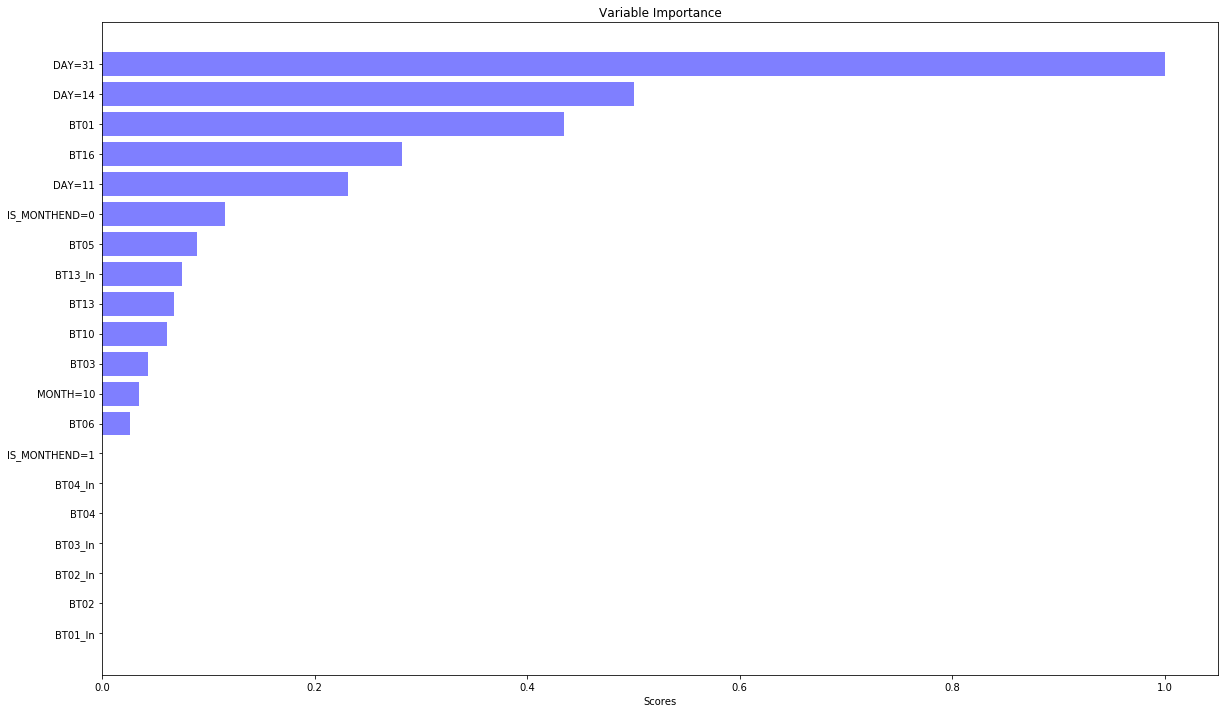

In [16]:

# Plot Feature Importance for LASSO
lasso=Lasso(random_state=0,alpha=0.5)
lasso.fit(X_train_d,y_train)
scores=np.abs(lasso.coef_)
scores4=scores/np.max(scores)

plot_feature_scores(scores4,X_train_d.columns)

### Combination 2: Random Forest Regressor
Using Feature Selection to reduce dimension and Grid Search Cross-Validation to get optimal parameters automatically

In [17]:

#  RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

rf  = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=10)

pl = Pipeline([ ('anova', anova), ('rf', rf)])
# Select the optimal percentage of features with grid search
pl = GridSearchCV(pl, {'anova__percentile': [30,40,50,60,70,80,90,100],'rf__max_depth':[4,5,6]}, cv=cv,verbose=False)
pl.fit(X_train_d, y_train)  # set the best parameters
print(pl.best_params_)
print(pl.best_score_)

y_train_pred=pl.predict(X_train_d)
y_test_pred=pl.predict(X_test_d)

res_log=evalResult('RandomForestRegressor train',wt_train,y_train,y_train_pred)
res_log=evalResult('RandomForestRegressor test',wt_test,y_test,y_test_pred)

#Select this combination's result as part of final result
res_train_pred['RandomForest']=y_train_pred
res_test_pred['RandomForest']=y_test_pred

{'anova__percentile': 80, 'rf__max_depth': 6}
0.7430230992

 RandomForestRegressor train
Root Mean Squared Error: 6.83
Variance score: 0.88
RandomForestRegressor train  MAPE=0.028

 RandomForestRegressor test
Root Mean Squared Error: 18.38
Variance score: 0.17
RandomForestRegressor test  MAPE=0.067


Plot feature importance for Random Forest Regressor

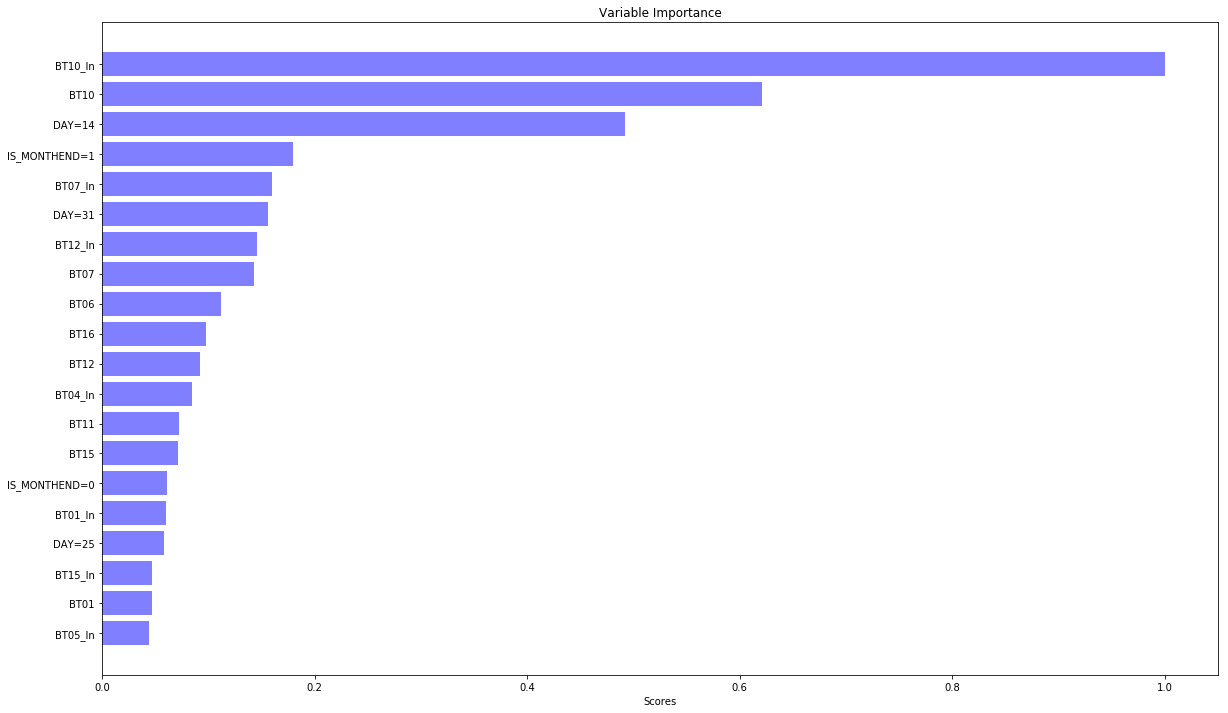

In [18]:
rf  = RandomForestRegressor(max_depth=6, random_state=0,n_estimators=10)
rf.fit(X_train_d, y_train)

scores=rf.feature_importances_
scores3=scores/np.max(scores)

plot_feature_scores(scores3,X_train_d.columns)

### Combination 3:  Feature Selection + Gradient Boosting Regressor
Using Feature Select to reduce dimension and Grid Search Cross-Validation to get optimal parameters automatically


In [19]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

gbr = GradientBoostingRegressor(**params)

pl = Pipeline([ ('anova', anova), ('gbr', gbr)])
pl = GridSearchCV(pl, {'anova__percentile': [60,70,80],'gbr__max_depth':[2,3,4],'gbr__n_estimators':[300,400]}, cv=cv,verbose=False)
pl.fit(X_train_d, y_train)  # set the best parameters
print(pl.best_params_)
print(pl.best_score_)

y_test_pred=pl.predict(X_test_d)
y_train_pred=pl.predict(X_train_d)

res_log=evalResult('GradientBoostingRegressor train',wt_train,y_train,y_train_pred)
res_log=evalResult('GradientBoostingRegressor test',wt_test,y_test,y_test_pred)

res_train_pred['GradientBoostingRegressor']=y_train_pred
res_test_pred['GradientBoostingRegressor']=y_test_pred

{'anova__percentile': 70, 'gbr__max_depth': 4, 'gbr__n_estimators': 400}
0.807065081705

 GradientBoostingRegressor train
Root Mean Squared Error: 5.21
Variance score: 0.93
GradientBoostingRegressor train  MAPE=0.023

 GradientBoostingRegressor test
Root Mean Squared Error: 17.45
Variance score: 0.25
GradientBoostingRegressor test  MAPE=0.066


## Step 4: Visualization of prediction result 


In [20]:
#predicted result of test dataset
res_test_pred


,Lasso,RandomForest,GradientBoostingRegressor
305,181.981313,190.006777,200.527427
306,179.272627,172.103785,196.233145
307,170.757936,178.231753,172.950420
308,169.429396,167.008322,171.420585
309,162.142985,153.606409,156.516856
310,153.174273,152.552997,152.956530
311,164.039854,167.008322,164.503554
312,165.730552,167.008322,167.224673
313,165.378774,172.207759,173.017589
314,176.203202,172.105176,189.434557


In [21]:
#result evaluation for all 3 combinations on train and test
res_log


,Algorithm,Train_Test,RMSE,R2_Score,MAPE
0,Lasso,train,13.975595,0.492909,0.058043
1,Lasso,test,18.170952,0.188809,0.060857
2,RandomForestRegressor,train,6.831870,0.878822,0.028234
3,RandomForestRegressor,test,18.376903,0.170317,0.067097
4,GradientBoostingRegressor,train,5.206888,0.929612,0.022571
5,GradientBoostingRegressor,test,17.452673,0.251672,0.066381


In [22]:
#result evaluation for all 3 combinations on train, sorted by RMSE
res_log[res_log['Train_Test']=='train'].sort_values(by=['RMSE'])


,Algorithm,Train_Test,RMSE,R2_Score,MAPE
4,GradientBoostingRegressor,train,5.206888,0.929612,0.022571
2,RandomForestRegressor,train,6.831870,0.878822,0.028234
0,Lasso,train,13.975595,0.492909,0.058043


In [23]:
#result evaluation for all 3 combinations on test, sorted by RMSE
res_log[res_log['Train_Test']==' test'].sort_values(by=['RMSE'])


,Algorithm,Train_Test,RMSE,R2_Score,MAPE
5,GradientBoostingRegressor,test,17.452673,0.251672,0.066381
1,Lasso,test,18.170952,0.188809,0.060857
3,RandomForestRegressor,test,18.376903,0.170317,0.067097



### Draw predicted results on test data

            Actual       Lasso  RandomForest  GradientBoostingRegressor
Date                                                                   
2016-11-01   175.0  181.981313    190.006777                 200.527427
2016-11-02   165.0  179.272627    172.103785                 196.233145
2016-11-03   210.0  170.757936    178.231753                 172.950420
2016-11-04   167.0  169.429396    167.008322                 171.420585
2016-11-05   193.0  162.142985    153.606409                 156.516856
2016-11-06   144.0  153.174273    152.552997                 152.956530
2016-11-07   175.0  164.039854    167.008322                 164.503554
2016-11-08   160.0  165.730552    167.008322                 167.224673
2016-11-09   160.0  165.378774    172.207759                 173.017589
2016-11-10   183.0  176.203202    172.105176                 189.434557
2016-11-11   256.0  182.279826    182.692694                 186.543442
2016-11-12   171.0  154.991375    151.721290                 157

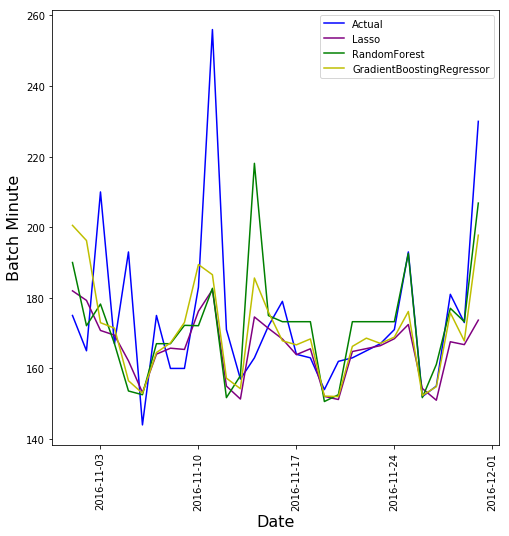

In [24]:
#Draw prediction result of test dataset for all combinations
def drawResults(test,actual,dfRes,colors):
    
    df=pd.DataFrame({'Actual':actual,'Date':test['DATE']})
    
    
    for i in range(len(dfRes.columns)):
        df[dfRes.columns[i]]=dfRes[dfRes.columns[i]]       
        
    df.index=df['Date']
    df.drop('Date',axis=1,inplace=True)
    


    print(df)
    # Plot outputs
    plt.figure(figsize=(8,8))
    ax1=plt.subplot(111)
    ax1.plot(df['Actual'], 'blue')
    for i in range(len(dfRes.columns)):
        ax1.plot(df[dfRes.columns[i]],colors[i])
        
        
    #ax1.set_ylim([0,500])
    ax1.legend()
    ax1.set_xlabel('Date', fontsize = 16)
    ax1.set_ylabel('Batch Minute', fontsize =16)
    plt.xticks(rotation='vertical')


    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    return

drawResults(wt_test,original_y_test,res_test_pred,['purple','g','y'])


## Step 5: Ensemble predicted results

Apply 3 algorithms to predict result, consider linear and unlieaner characteristics of MBJ elapsed time we observed in Data Exploration.

1. GradientBoosting
2. LASSO
3. Random Forest

Get the __*mean()*__ of them as result output, use RMSE of training data as __*stderr*__ to calculate upper bound and lower bound



Ensambled result

Root Mean Squared Error: 19.79
Variance score: 0.25
            Actual  Lower_Bound   Predicted  Upper_Bound
Date                                                    
2016-11-01   175.0   167.311393  190.838506   214.365618
2016-11-02   165.0   159.009407  182.536519   206.063631
2016-11-03   210.0   150.452924  173.980036   197.507149
2016-11-04   167.0   145.758989  169.286101   192.813213
2016-11-05   193.0   133.894971  157.422083   180.949196
2016-11-06   144.0   129.367488  152.894600   176.421712
2016-11-07   175.0   141.656798  165.183910   188.711023
2016-11-08   160.0   143.127403  166.654516   190.181628
2016-11-09   160.0   146.674262  170.201374   193.728486
2016-11-10   183.0   155.720533  179.247645   202.774758
2016-11-11   256.0   160.311541  183.838654   207.365766
2016-11-12   171.0   131.122803  154.649915   178.177028
2016-11-13   157.0   130.981916  154.509029   178.036141
2016-11-14   163.0   169.239966  192.767078   216.294190
2016-11-15   172.0

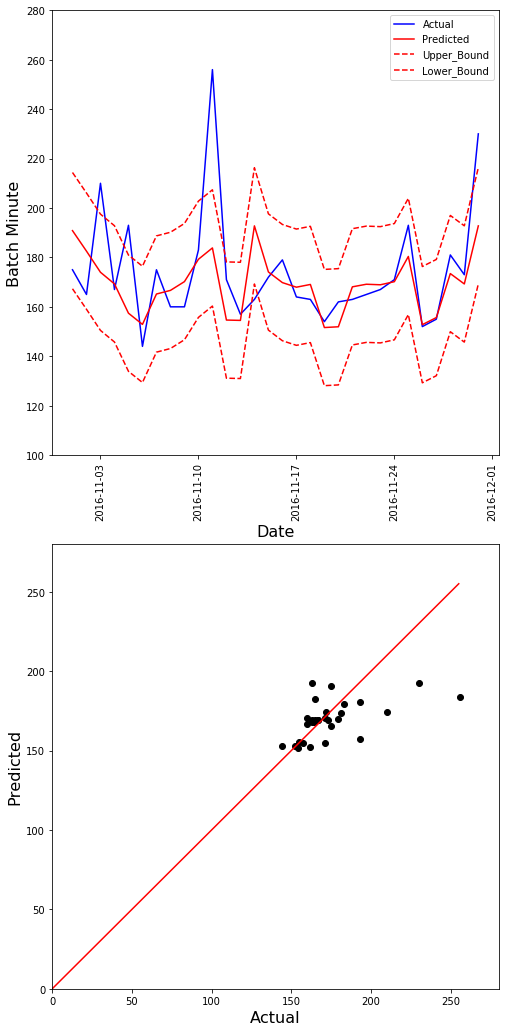

Ensambled result  MAPE=0.065


In [25]:
#Draw ensembled predicted result with upper bound and lower bound
def evalResultRange(algname,test,actual,predicted,std,times=3):
    print(algname)
    print('================================================================================================\n')
    print("Root Mean Squared Error: %.2f" % np.sqrt(mean_squared_error(actual, predicted)))
     # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(actual, predicted))
    df=pd.DataFrame({'Actual':actual,'Predicted':predicted,'Date':test['DATE'],
                     'Upper_Bound':predicted+times*std,'Lower_Bound':predicted-times*std})
    df.index=df['Date']
    df.drop('Date',axis=1,inplace=True)
    df['Lower_Bound'][df['Lower_Bound']<0]=0
    print(df)
    # Plot outputs
    plt.figure(figsize=(8,18))
    ax1=plt.subplot(211)
    ax1.plot(df['Actual'], 'b')
    ax1.plot(df['Predicted'],'r')
    ax1.plot(df['Upper_Bound'],'r--')
    ax1.plot(df['Lower_Bound'],'r--')
    ax1.set_ylim([100,280])
    ax1.legend()
    ax1.set_xlabel('Date', fontsize = 16)
    ax1.set_ylabel('Batch Minute', fontsize =16)
    plt.xticks(rotation='vertical')
    
    ax2=plt.subplot(212)
    ax2.set_xlim([0,280])
    ax2.set_ylim([0,280])
    ax2.scatter(actual, predicted,  color='black')
    l=max(actual)
    x= np.arange(0.0, l, 1)
    ax2.plot(x,x,'r')
    ax2.set_xlabel('Actual', fontsize = 16)
    ax2.set_ylabel('Predicted', fontsize = 16)

    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    #plt.close()
    #print(*zip(actual,predicted))
    print(algname,' MAPE=%.3f'% calMAPE(actual,predicted))
    return
    

from sklearn.metrics import mean_squared_error
from math import sqrt
res_final_train=pd.DataFrame()
res_final_train['mean']=res_train_pred.mean(axis=1)
rmse=sqrt(mean_squared_error(y_train, res_final_train['mean']))
res_final_test=pd.DataFrame()
res_final_test['mean']=res_test_pred.mean(axis=1)
res_final_test['std']=rmse
evalResultRange('Ensambled result',wt_test,original_y_test,res_final_test['mean'],res_final_test['std'],3)
